In [1]:
from transformers import DetrFeatureExtractor, DetrForSegmentation
from PIL import Image
import requests
import torch
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np

In [2]:
feature_extractor = DetrFeatureExtractor.from_pretrained('facebook/detr-resnet-50-panoptic')
model = DetrForSegmentation.from_pretrained('facebook/detr-resnet-50-panoptic')


In [23]:
def center_to_corners(bounds, W, H):
    x, y, w, h = bounds
    x1, y1, x2, y2 = (x - 0.5*w)*W, (y - 0.5*h)*H,  (x + 0.5*w)*W, (y + 0.5*h)*H
    x1, y1, x2, y2 = np.clip(x1, 0, W), np.clip(y1, 0, H), np.clip(x2, 0, W), np.clip(y2, 0, H)
    return x1, y1, x2, y2

def get_pred(url, feature_extractor, model, debug=False):
    image = Image.open(requests.get(url, stream=True).raw) if 'http' in url else Image.open(url)

    inputs = feature_extractor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits[0]
    bboxes_raw = outputs.pred_boxes.tolist()[0]
    masks_raw = outputs.pred_masks[0]
    
    W, H = image.size
    topk = torch.softmax(logits, dim=1).topk(1)
    values, indices = list(topk.values.squeeze().tolist()), list(topk.indices.squeeze().tolist())
    bboxes = [center_to_corners(x, W, H) for x in bboxes_raw]
    thresh = 0.5
    masks = [
        (torch.nn.functional.interpolate(mask_raw.unsqueeze(0)[:,None], tuple([H, W])).squeeze().sigmoid() > thresh).numpy()
        for mask_raw in masks_raw
    ]
    
    res = [
        {
            'idx': e, 
            'label': model.config.id2label[i], 
            'score': v, 
            'bbox': box, 
            'mask': mask
        } for e, (v, i, box, mask) in 
        enumerate(zip(values, indices, bboxes, masks)) if 
        (i<250) and (v>0.5)
    ]
    if debug:
        visualize_prediction(image, res)
    return res, image

def visualize_prediction(img, res):
    plt.figure(figsize=(16, 10))
    plt.imshow(img)
    ax = plt.gca()
    for ele in res:
        (xmin, ymin, xmax, ymax), label, score = ele['bbox'], ele['label'], ele['score']
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color="red", linewidth=3, linestyle="--"))
        ax.text(xmin, ymin, f"{label}: {score:0.2f}", fontsize=15, bbox=dict(facecolor="yellow", alpha=0.5))
        plt.imshow(ele['mask'], alpha=0.2)
    plt.axis("off")
    plt.show()

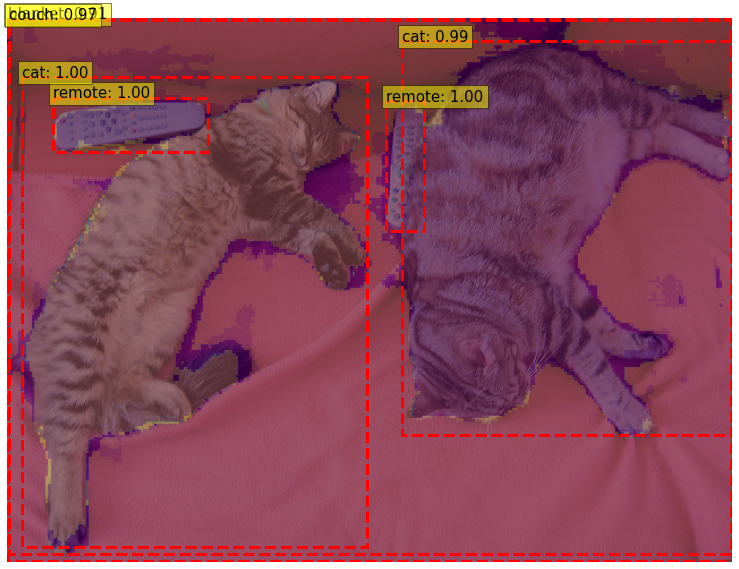

In [24]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
res, image = get_pred(url, feature_extractor, model, True)

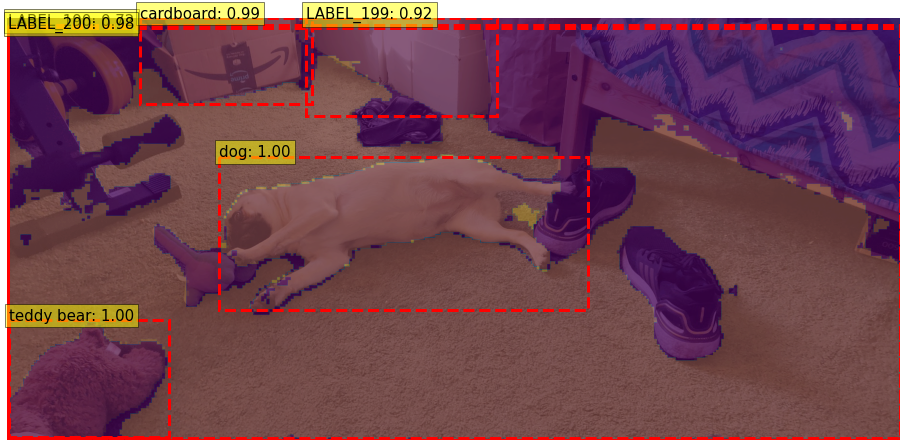

In [25]:
url = '/home/nuwandavek/Desktop/kiwi.jpg'
res, image = get_pred(url, feature_extractor, model, True)

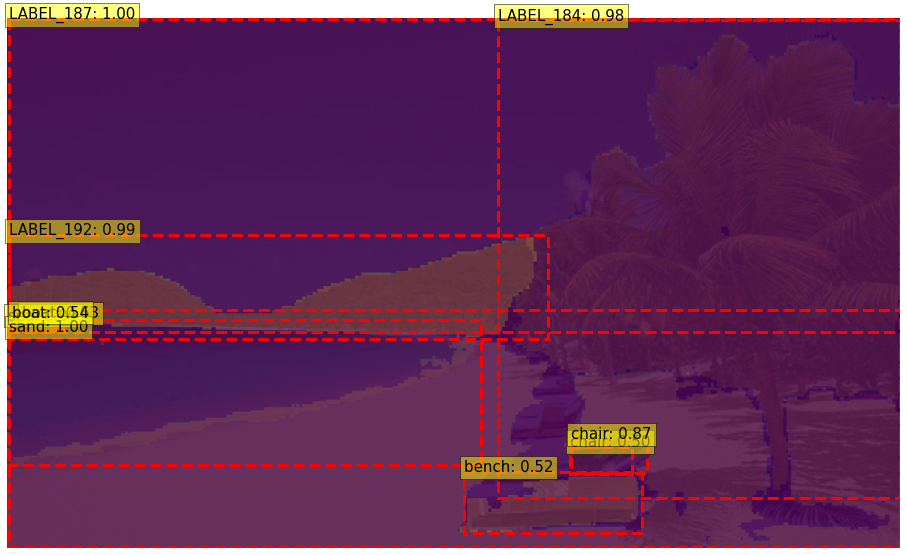

In [26]:
url = '/home/nuwandavek/Desktop/kiw2i.jpg'
res, image = get_pred(url, feature_extractor, model, True)

In [2]:
from transformers import YolosFeatureExtractor, YolosForObjectDetection
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

feature_extractor = YolosFeatureExtractor.from_pretrained('hustvl/yolos-base')
model = YolosForObjectDetection.from_pretrained('hustvl/yolos-base')

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)

# model predicts bounding boxes and corresponding COCO classes
logits = outputs.logits
bboxes = outputs.pred_boxes

Downloading:   0%|          | 0.00/275 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.04k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/488M [00:00<?, ?B/s]

In [1]:
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
import torch
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



max_length = 16
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
def predict_step(image_paths):
    images = []
    for url in image_paths:
        i_image = Image.open(requests.get(url, stream=True).raw) if 'http' in url else Image.open(url)
        if i_image.mode != "RGB":
            i_image = i_image.convert(mode="RGB")

    images.append(i_image)

    pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)

    output_ids = model.generate(pixel_values, **gen_kwargs)

    preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    preds = [pred.strip() for pred in preds]
    return preds




In [8]:
url1 = 'http://images.cocodataset.org/val2017/000000039769.jpg'
url2 = '/home/nuwandavek/Desktop/kiwi.jpg'
url3 = '/home/nuwandavek/Desktop/kiw2i.jpg'
predict_step([url1])

['a cat laying on top of a couch next to another cat']

In [8]:
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

In [3]:
a = model.get_text_features(
    **processor(text="a cat laying on top of a couch next to another cat", return_tensors="pt")
).tolist()
a /= np.linalg.norm(a)


a2 = model.get_text_features(
    **processor(text="dogs running in the woods", return_tensors="pt")
).tolist()

a2 /= np.linalg.norm(a2)

In [4]:
b = model.get_image_features(
    **processor(images=image, return_tensors="pt")
).tolist()

b /= np.linalg.norm(b)

In [5]:
np.dot(a,b.T), np.dot(a2,b.T)

(array([[0.24753723]]), array([[0.07438291]]))

In [9]:
a

array([[-6.48451133e-02,  2.75971170e-02,  5.73746733e-03,
        -1.63903310e-02,  2.27285053e-02, -8.29922168e-03,
        -1.46619670e-02,  1.59972533e-02, -6.48325409e-02,
         1.25808470e-02, -3.15869407e-02, -5.36514009e-03,
         3.85268929e-02,  1.93826186e-02,  9.14645329e-03,
         1.71343637e-02,  9.21997663e-03, -1.25429459e-02,
        -7.80557849e-02,  3.98935763e-03,  2.73913772e-04,
        -1.69418966e-02,  1.15840662e-02, -1.49106060e-02,
        -6.73072386e-03, -2.13488982e-02, -3.87056002e-02,
        -3.68921065e-02, -8.15405279e-03,  2.92583153e-02,
         1.02933255e-02,  3.79055514e-04,  1.13241933e-02,
         1.43554945e-03,  2.72630767e-03,  2.88858973e-03,
         1.28475600e-03,  2.34293847e-02, -3.53933870e-02,
         7.11429905e-03,  6.68577303e-03,  1.01736838e-02,
        -2.65873984e-02, -5.29553697e-02, -2.73444274e-02,
        -1.70386606e-02,  1.09169225e-03,  2.20423156e-03,
        -2.63976809e-02,  8.80025164e-03, -1.97797259e-0

In [55]:
logits_per_image

tensor([[18.9041, 11.7159]], grad_fn=<PermuteBackward0>)